In [1]:
import sys

sys.path.append('..')

import os
import pickle
from copy import deepcopy
from functools import partial
from itertools import islice
from os import environ
from pickle import dump

import matplotlib.pyplot as plt
import wandb
from freegroup.sampling import freegroup
from freegroup.sampling.helper import get_rng
from freegroup.tools import Comm, flatten, to_string
from iteration_utilities import repeatfunc, unique_everseen
from sklearn.model_selection import train_test_split
from tokenizer import build_tokenizer
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from utils import train_collate_fn

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
tokenizer = build_tokenizer('word-level', fdim=2, add_commutator_tokens=False,
                            add_prompt_tokens=True, add_post_processor=True)

In [3]:
# tokenizer.decode(tokenizer('-1 1')['input_ids'], skip_special_tokens=True) # HOWTO use tokenizer
# to_string([1, -3, 1])

In [4]:
root = '/main'
samplers_path = f'{root}/draft-v2/data/CFG_samplers/toy_whitehead_n_3_L_50.pkl'
with open(samplers_path, 'rb') as file:
    samplers = pickle.load(file)
R, S = samplers

In [5]:
"""params for dataset generation"""

seed = 0
rng = get_rng(seed)

# free group rank
fdim = 2
# words that generate normal closures : r = a^3, s=[a,b]
r = [1, 1, 1] # group connections (can be other)
s = [-1, -2, 1, 2] # group connections (can be other)

# max length
L = 50
# train dataset size
N = int(1e5)

In [6]:
def get_whitehead_multilabel(label):
    if label == 's':
        return [1]
    elif label == 'r':
        return [0]
    elif label == 'sr':
        return [0, 1]
    elif label == 'f':
        return []
    elif label == 'c':
        return [0, 1, 2]

In [7]:
def sample(n_samples=1e3, rng=rng, sampler=None, label=None):
    """
    return a list of samples for certain sampler
    """
    def fn():             
        length = rng.integers(1, L + 1)
        try:
            word = sampler(length=length, rng=rng)
            return {
                "label": label,
                "multilabel" : get_whitehead_multilabel(label),
                "word_str" : to_string(word),
                }
        except:
            return None
        
    # some itertools magic to exclude duplicates and handle exceptions of samplers
    iterator = repeatfunc(fn) 
    iterator = filter(lambda x: x is not None, iterator)
    iterator = unique_everseen(iterator)
    iterator = islice(iterator, n_samples)

    return list(tqdm(iterator, total=int(n_samples)))

In [8]:
def sample_freegroup(n_samples=1e3, rng=rng, label='f'):
    def fn():
        length = rng.integers(1, L + 1)
        word = freegroup(2, length, rng=rng)
        return {
            "label": label,
            "multilabel" : get_whitehead_multilabel(label), #if coin else 's',
            "word_str" : to_string(word),
            }
    iterator = repeatfunc(fn)
    iterator = unique_everseen(iterator)
    iterator = islice(iterator, n_samples)

    return list(tqdm(iterator, total = int(n_samples)))

In [19]:
def sample_comm(n_samples=1e3, rng=rng, samplers=None, label='c'):
    # R, S = samplers
    def fn():
        words = []
        for sampler in samplers:
            flag = False
            while not flag:
                length = rng.integers(1, L // 5 + 1)
                try:
                    word = sampler(length=length, rng=rng)
                    words.append(word)
                    flag = True
                except:
                    pass

        coin = rng.integers(low = 0, high = 2)
        if coin:
            result = flatten(Comm(words))
        else:
            result = flatten(Comm(words[::-1]))

        return {
            "label": label,
            "multilabel" : get_whitehead_multilabel(label), #if coin else 's',
            "word_str" : to_string(result),
                    }


    iterator = repeatfunc(fn)
    iterator = unique_everseen(iterator)
    iterator = islice(iterator, n_samples)

    return list(tqdm(iterator, total = int(n_samples)))

In [20]:
dataset_r = sample(N // 2, sampler=R, label='r')
dataset_s = sample(N // 2, sampler=S, label='s')
dataset_f = sample_freegroup(N // 2)
dataset_c = sample_comm(N // 2,  samplers=samplers)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[]
[[-1, -1, -1]]
[[-1, -1, -1]]
[[-1, -1, -1]]
[]
[]
[]
[[1, 1, 2, -1, -1, -1, -2, 1]]
[]
[[-1, -2, 1, 1, 1, 2, 1]]
[[-1, -2, 1, 1, 1, 2, 1]]
[[-1, -2, 1, 1, 1, 2, 1]]
[]
[[-1, -1, -1]]
[[-1, -1, -1]]
[]
[[1, 1, 1, -2, 1, 1, 1, 2]]


In [21]:
dataset = dataset_r + dataset_s + dataset_f + dataset_c

In [22]:
train, test = train_test_split(deepcopy(dataset), test_size=0.1)

In [23]:
"""make test samples with short length and intersection label (i)"""
for i in range(len(test)):
    test[i]['multilabel'] = [0, 1]
    test[i]['word_str'] = to_string(test[i]['word_str'].split()[:5])
    test[i]['label'] = 'i'

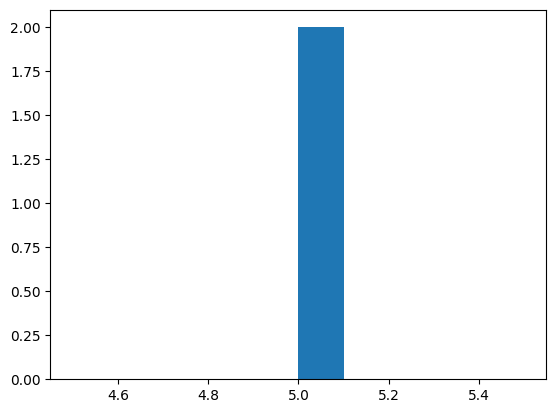

In [24]:
for el in [test]:
    plt.hist(list(map(lambda x: len(x['word_str'].split()), el)))
    plt.show()

In [25]:
min(train, key=lambda x: len(x['word_str'].split()))

{'label': 's', 'multilabel': [1], 'word_str': '1 -2 1 2 -1 -1'}

In [26]:
df = DataLoader(train, 16, collate_fn=partial(train_collate_fn, tokenizer=tokenizer, fdim=fdim)) # What is dataloader
# !!!ATTENTION!!! it's a coincidence that train_collate_fn with fdim=2 is suitable for whitehead problem.
# In general this method should be adapted for certain prompt label size (now the size is [1: 1 + fdim + 1 + 1], i.e. fdim + 2 size)

In [28]:
el = next(iter(df))
el.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

# LOG TO WANDB

In [262]:
environ['WANDB_USERNAME']='pavel-tikhomirov'
environ['WANDB_DIR']=f'/main/draft-v2/{environ["WANDB_USERNAME"]}-runs/'
environ['TOKENIZERS_PARALLELISM']='false'

In [267]:
run = wandb.init(entity = 'ml-in-algebraic-topology', project = 'whitehead', job_type = 'build-dataset')

In [268]:
data = wandb.Artifact(f'fdim-{fdim}-whitehead', type='dataset', #-trivial
                      description=f'fdim={fdim}. R and S dataset with ratio x^n, [x, y], freegroup and commutator. Train & test. Ratio 0.9. Prefix of length 5, label intersection',
                      metadata={
                              'fdim': fdim,
                              'N': N * 2,
                              'n': n,
                              'max_length': L
                          }
    )
with data.new_file('train.pkl', 'wb') as file:
        dump(train, file)
with data.new_file('test.pkl', 'wb') as file:
        dump(test, file)
run.log_artifact(data)

<Artifact fdim-2-whitehead>

In [269]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


# DOWNLOAD FROM WANDB

In [12]:
import sys

sys.path.append('..')
import pickle
from os import environ
from pathlib import Path

import wandb
from lming.utils import download_artifact

In [13]:
environ['WANDB_USERNAME']='pavel-tikhomirov'
environ['WANDB_DIR']=f'/main/draft-v2/{environ["WANDB_USERNAME"]}-runs/'
environ['TOKENIZERS_PARALLELISM']='false'

In [14]:
run = wandb.init(entity='ml-in-algebraic-topology', project='whitehead')
artifact_dir = download_artifact('fdim-2-whitehead:v0')

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb:   2 of 2 files downloaded.  


In [18]:
with open(Path(artifact_dir) / "test.pkl", 'rb') as f:
    data = pickle.load(f)

In [19]:
data

[{'label': 'i', 'multilabel': [0, 1], 'word_str': '1 -2 1 2 -1'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '1 1 1 1 -2'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '-2 1 2 -1 2'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '2 1 1 2 -1'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '2 1 -2 -1 2'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '-1 2 2 1 2'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '2 -1 -1 -1 2'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '-1 -2 -2 -1 -1'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '-1 -1 -1 -2 -1'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '-1 -2 1 -2 -2'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '2 -1 2 1 1'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '-1 2 -1 -1 -1'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '-1 2 1 -2 1'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '2 -1 2 -1 2'},
 {'label': 'i', 'multilabel': [0, 1], 'word_str': '2 1 1 1 -2'},
 {'l

In [5]:
from os import environ
import torch

In [6]:
torch.set_default_dtype('float16')

TypeError: invalid dtype object: only floating-point types are supported as the default type